# <center>Generative Adversarial Network</center>

In [8]:
# Authors: Fernando Fêtis & Felipe Tobar, Sept 2024

import torch
import tqdm
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}.')

Device: mps.


## Datos de entrenamiento

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
    ])

dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## GAN

### Red generadora

In [10]:
class Generator(nn.Module):
    def __init__(self, output_shape, hidden_dim=100):
        super().__init__()

        self.output_shape = output_shape
        self.hidden_dim = hidden_dim

        channels, height, width = output_shape

        self.layer = nn.Sequential(
            nn.Linear(hidden_dim, 128), nn.LeakyReLU(0.2),
            nn.Linear(128, 256), nn.BatchNorm1d(256), nn.LeakyReLU(0.2),
            nn.Linear(256, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.2),
            nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.LeakyReLU(0.2),
            nn.Linear(1024, channels * height * width), nn.Tanh()
        )

    def forward(self, x):
        batch_size = len(x)
        x = self.layer(x)
        return x.view(batch_size, *self.output_shape)

### Red discriminadora

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        channels, height, width = input_shape

        self.layer = nn.Sequential(
            nn.Linear(channels * height * width, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = nn.Flatten()(x)
        return self.layer(x)

### Entrenamiento

In [12]:
def train_gan(generator, discriminator, dataloader, epochs, lr=0.002, betas=(0.5, 0.999)):

    generator.to(device)
    discriminator.to(device)
    criterion = nn.BCELoss()

    # Optimizadores:
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr, betas)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr, betas)

    try:
        progressbar = tqdm.trange(epochs)
        for epoch in progressbar:

            epoch_discriminator_loss = 0
            epoch_generator_loss = 0

            for x_true, _ in dataloader:

                batch_size = x_true.size(0)
                labels_ones = torch.ones(batch_size, 1).to(device)
                labels_zeros = torch.zeros(batch_size, 1).to(device)

                # ---------- Entrenamiento discriminador ----------

                # Datos reales:
                x_true = x_true.to(device)
                x_true_pred = discriminator(x_true)
                x_true_loss = criterion(x_true_pred, labels_ones)

                # Datos sintéticos:
                z = torch.randn(batch_size, generator.hidden_dim, device=device)
                x_fake = generator(z)
                x_fake_pred = discriminator(x_fake)
                x_fake_loss = criterion(x_fake_pred, labels_zeros)

                discriminator_loss = x_true_loss + x_fake_loss
                epoch_discriminator_loss += discriminator_loss.item()
                discriminator_optimizer.zero_grad()
                discriminator_loss.backward()
                discriminator_optimizer.step()

                # ---------- Entrenamiento generador ----------

                # Datos sintéticos:
                z = torch.randn(batch_size, generator.hidden_dim, device=device)
                x_fake = generator(z)
                x_fake_pred = discriminator(x_fake)
                generator_loss = criterion(x_fake_pred, labels_ones)

                epoch_generator_loss += generator_loss.item()
                generator_optimizer.zero_grad()
                generator_loss.backward()
                generator_optimizer.step()

            epoch_discriminator_loss /= len(dataloader)
            epoch_generator_loss /= len(dataloader)
            progressbar.set_postfix(D_loss=epoch_discriminator_loss, G_loss=epoch_generator_loss)

    except KeyboardInterrupt:
        print('Entrenamiento interrumpido.')

In [13]:
# Tamaño de entrada y salida:
image_shape = dataset[0][0].shape

# Redes generadora y discriminadora:
generator = Generator(image_shape)
discriminator = Discriminator(image_shape)

# Entrenamiento:
train_gan(generator, discriminator, dataloader, epochs=50)

100%|████████████████| 50/50 [05:13<00:00,  6.27s/it, D_loss=1.35, G_loss=0.867]


### Generación de muestras

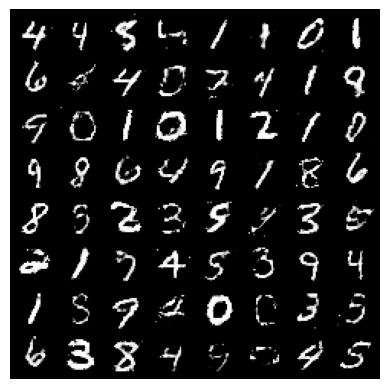

In [16]:
def generate_images(generator, filename, n_samples=64):

    generator.eval()
    z = torch.randn(n_samples, generator.hidden_dim).to(device)

    with torch.no_grad():
        samples = generator(z).cpu()
        samples = make_grid(samples).permute(1,2,0)

    plt.imshow(samples.clip(0,1), cmap='gray')
    plt.axis('off')
    plt.savefig(f'../img/{filename}.pdf', bbox_inches='tight')
    plt.show()

generate_images(generator, filename='gan_mnist')

## GAN para `FashionMNIST`

### Datos de entrenamiento

In [17]:
fashion_dataset = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)
fashion_dataloader = DataLoader(fashion_dataset, batch_size=128, shuffle=True)

100%|██████████████████████████| 26421880/26421880 [00:11<00:00, 2234762.60it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████| 29515/29515 [00:00<00:00, 1260743.06it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████| 4422102/4422102 [00:00<00:00, 4983273.71it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████████████████████████████| 5148/5148 [00:00<00:00, 6872144.17it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [18]:
# Tamaño de entrada y salida:
image_shape = fashion_dataset[0][0].shape

# Redes generadora y discriminadora:
fashion_generator = Generator(image_shape)
fashion_discriminator = Discriminator(image_shape)

# Entrenamiento:
train_gan(fashion_generator, fashion_discriminator, fashion_dataloader, epochs=50)

100%|████████████████| 50/50 [05:18<00:00,  6.38s/it, D_loss=1.37, G_loss=0.896]


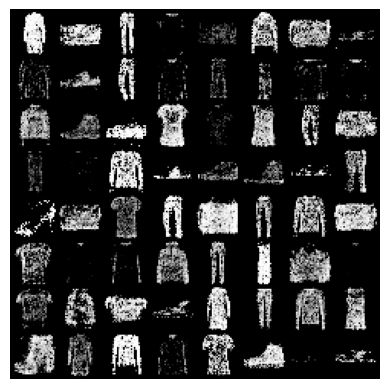

In [19]:
generate_images(fashion_generator, filename='gan_fashion_mnist')